# Future greek without nested stochastics 2 #


## Introduction ##

Previously we demonstrated how to train a neural network as delta function, with time and index level as input. One question we get often is what if interest rate and volatility changed? Do we need to retrain? Here we will develop a more advanced technique to train delta neural network with interest rate and volatility as input as well. 

Just like the previous work, the inputs to the process are:

* One set of scenario
* Cashflows

But scenarios  will be constructed differently. They will cover paths with a range of volatility and interest rate. All interest rate and volatility shift happen at time zero. Each path has deterministic interest rate and volatility. 

Additional to the delta neural network, we will train a separate price network simultaneously. The delta neural network has 4 inputs: time, index level, interest rate and volatility. The price network only has 3 inputs: index level, interest rate and volatility. It represents the price of the option at time zero. 

The training target is still to get the variance of after hedge error as small as possible. i.e. we will minimize present value of (option payout + delta hedge cashflow) - price neural network output. 


Again, We will use a simple call with lognormal scenarios as an example. The delta and price calculated by the trained neural network is very close to the Black Scholes formula.



## The training code


We recommand to run the example on Google Colab. It's free GPU!

First, make sure there is a GPU. 

In [1]:
!nvidia-smi

Tue Jan 05 13:45:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.09       Driver Version: 457.09       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:01:00.0  On |                  N/A |
| 23%   40C    P0    36W / 125W |    918MiB /  6144MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import numpy as np
print("torch version: ", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

torch version:  1.7.1
cuda


### Scenarios and cashflow 


random generate rate, vol, and initial index level.
train two network at once
* price network at time zero, function of s, v, r
* delta network at all time, function of s, t, v, r

Parameters: one year (252 day) option. Daily hedging. 
* 10-25% annualized volatility. 
* The risk free rate is 1-3%. 
* Drift of the scenario is set to 0%. 
* initial s range 0.5-1.5


In [3]:
d=252      # days of simulation
drift=0.0  # drift of the scenario
strike=1   # strike price

K1, K2 = 3, 10
N1=2**K1   #batch count
N2=2**K2   #batch size

8 batch of 1024 scenarios. Similar result could be achieved with a much smaller set of scenarios, but not as robustly.

In [4]:
rf=torch.rand(N1,N2,device=device)*0.1+0.01     #risk free rate
sigma=torch.rand(N1,N2,device=device)*0.15+0.1  #volatility
s0=torch.rand(N1,N2,device=device)+0.5          #initial index level

dt=torch.tensor(1/d,device=device)
sq_dt=torch.sqrt(dt)

s = torch.randn((N1,N2,d),device=device)
idx=torch.empty((N1,N2,d+1),device=device)
idx[...,0]=s0
for i in range(d):
    idx[...,i+1]=idx[...,i]*torch.exp((drift-sigma**2/2)*dt+s[...,i]*sigma*sq_dt)


payout=torch.clamp(idx[:,:,-1]-strike,min=0.0)
t=torch.linspace(0,1,d+1,device=device)
disc=torch.exp(-torch.tensordot(rf,t,0))

pv_payout=payout*disc[...,-1]
                      
chg=idx[...,1:]*disc[...,1:]-idx[...,:-1]*disc[...,:-1]
#the chg is discounted to time zero already

Format data for training 

In [5]:
t=torch.linspace(1,1/d,d,device=device)    #time to maturity
t=t.view(1,1,d,1)
t=t.expand(N1,N2,-1,-1)

s=idx[...,:-1].view(N1,N2,d,1)

r=rf.view(N1,N2,1,1)
r=r.expand(-1,-1,d,-1)

v=sigma.view(N1,N2,1,1)
v=v.expand(-1,-1,d,-1)

tsrv=torch.cat((t,s,r,v),3)

srv=torch.cat((s[...,0,:],r[...,0,:],v[...,0,:]),2)

### Delta neural network model

Here is the delta neural network model and price neural network model.

The delta neural network has 4 inputs: time to maturity, index level, risk free rate and volatility. There is only one output: delta. There are two middle layer of 24 and 12 nodes. The count of trainable parameter is less than 500. So it is a very small network by modern standard. The result could be improved slightly with a bigger network say two 32 node middle layers. The training speed will decrease.

The price network only have 3 inputs and otherwise is very similar to the delta neural network. 

At the last layer, we use sigmoid activation function for delta and softplus activation for price. This is to take advantage of similarity in shape between Black-Scholes formuls to the those activation function.

In [6]:
model_delta = torch.nn.Sequential(
    torch.nn.Linear(4, 24),
    torch.nn.Tanh(),
    torch.nn.Linear(24,12),
    torch.nn.Tanh(),
    torch.nn.Linear(12, 1),
    torch.nn.Sigmoid(),
)
model_delta = model_delta.to(device)


model_price = torch.nn.Sequential(
    torch.nn.Linear(3, 24),
    torch.nn.Tanh(),
    torch.nn.Linear(24,12),
    torch.nn.Tanh(),
    torch.nn.Linear(12, 1),
    torch.nn.Softplus(),
)
model_price = model_price.to(device)

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nDelta network paramerer count\n",count_parameters(model_delta))


Delta network paramerer count
 433


### Training


We will use AdamW optimizer first. Then use LBFGS solver with strong_wolfe line search. 

AdamW is a more robust optimizer. Given enough time, AdamW tend to converge to a very good solution. 

LBFGS is a higher order optimizer and tend to converge faster when close to the optimal solution. LBFGS is memory intensive and not as stable. Our neural network is small enough that LBFGS actually works  well with proper warm up.


The training target is that pv(payout)+pv(hedge cf)-price_network_output should be close to zero. 

In [8]:
import time
import itertools
params=[model_delta.parameters(),model_price.parameters()]

optimizer = torch.optim.AdamW(itertools.chain(*params),lr=0.01,
                              weight_decay=1e-10,amsgrad=True)
t1=time.time()
for j in range(400):
    for i in range(N1):
        optimizer.zero_grad()
        delta=model_delta(tsrv[i])
        delta=delta.view(N2,d)
        asset_gl=torch.sum(delta*chg[i],dim=1)
        hedged_price=-asset_gl+pv_payout[i]
        
        price_error=model_price(srv[i]).flatten()-hedged_price
        
        loss=torch.sum(price_error*price_error)
        loss.backward()
        optimizer.step()    
    if j%50==0: print(j,loss.item())
t2=time.time()
print("{:.3}".format(t2-t1), " seconds")

0 47.24791717529297
50 0.20460245013237
100 0.10086885094642639
150 0.07203109562397003
200 0.05141092836856842
250 0.03717436641454697
300 0.029676005244255066
350 0.02547796443104744
9.98  seconds


LBFGS optimizer works better less noise. So we run the LBFGS across all  scenarios. 

In [9]:
params=[model_delta.parameters(),model_price.parameters()]
optimizer = torch.optim.LBFGS(itertools.chain(*params),lr=0.85,
                             max_iter=800,line_search_fn ="strong_wolfe",
                             tolerance_grad=1e-30, tolerance_change=1e-30)

def closure():
    optimizer.zero_grad()

    delta=model_delta(tsrv)
    delta=delta.view(N1,N2,d)
    asset_gl=torch.sum(delta*chg,dim=2)
    hedged_price=-asset_gl+pv_payout
    price_error=model_price(srv).flatten()-hedged_price.flatten()
    loss=torch.sum(price_error*price_error)
    loss.backward()
    return loss  

t1=time.time()
print("init",closure().item())
optimizer.step(closure)
print("lbfgs",closure().item())
t2=time.time()
print("{:.3}".format(t2-t1), " seconds")

init 0.18140986561775208
lbfgs 0.055970288813114166
33.9  seconds


In [10]:
# for name, param in model_price.named_parameters():
#     if param.requires_grad:
#         print (name, param.data,param.grad)

## Comparison of neural network detla to Black Scholes delta

Standard Black Scholes formulas for call

In [11]:
import scipy.stats as si
def call_bs(S, K, r, q, T, sigma):
#    standard black scholes formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    call = (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - \
            K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return call
  
def delta_bs(S, K, r, q, T, sigma):
#    standard black scholes delta formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    delta =  np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)        
    return delta

In [12]:
def norm_cdf(x):
    return torch.erfc(-x/np.sqrt(2))/2

def delta_bs_torch(S, K, r, q, T, sigma):
#    standard black scholes delta formula for call
#    pytorch version
    d1 = (torch.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * torch.sqrt(T))
    delta =  torch.exp(-q * T) * norm_cdf(d1)        
    return delta


Chart the difference

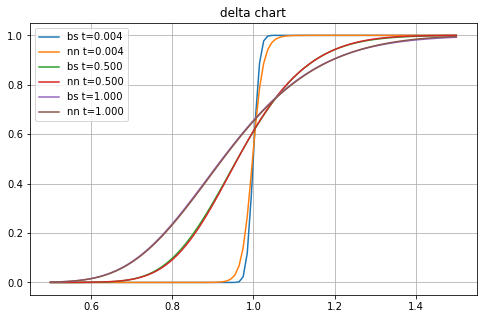

In [13]:
import matplotlib.pyplot as plt

plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(8,5))
plt.grid(True)

rfc=0.06
tl=[.004,.5,1.0]
for tc in tl:
    sc=torch.linspace(0.5,1.5,100,device=device)
    tsrvc=torch.zeros((100,4),device=device)
    tsrvc[:,0]=tc
    tsrvc[:,1]=sc
    tsrvc[:,2]=rfc       #rate
    tsrvc[:,3]=0.2
    
    d_bs=delta_bs(sc.cpu().numpy(),1,rfc,0,tc,0.2)
    d_nn=model_delta(tsrvc)
    plt.plot(sc.cpu().numpy(),d_bs,label="bs t="+ "%.3f" % tc)
    plt.plot(sc.cpu().numpy(),d_nn.cpu().view(100).detach().numpy(),
           label="nn t="+ "%.3f" % tc)

plt.title("delta chart")
plt.legend()
#plt.savefig("test.svg")
plt.show()

Typically we should see the neural network delta and Black Scholes delta right on top of each other. For t=0.004 (1 day before the expiration) the slope of the delta curve(gamma) is extremely steep.   The neural network delta is not as steep. This is partially due to the neural network is optimizing for daily rebalance instead of continuous rebalancing.  

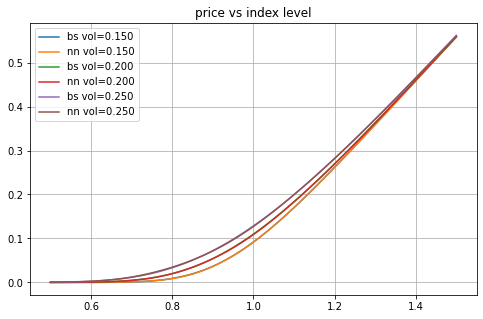

In [14]:
plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(8,5))
plt.grid(True)

rfc=0.06
vols=[.15,.2,.25]
for vc in vols:
    sc=torch.linspace(0.5,1.5,100,device=device)
    srvc=torch.zeros((100,3),device=device)

    srvc[:,0]=sc
    srvc[:,1]=rfc
    srvc[:,2]=vc
    
    p_bs=call_bs(sc.cpu().numpy(),1.0,rfc,0.0,1.0,vc)
    p_nn=model_price(srvc)
    plt.plot(sc.cpu().numpy(),p_bs,label="bs vol="+ "%.3f" % vc)
    plt.plot(sc.cpu().numpy(),p_nn.cpu().view(100).detach().numpy(),
           label="nn vol="+ "%.3f" % vc)

plt.title("price vs index level")
plt.legend()
#plt.savefig("test.svg")
plt.show()

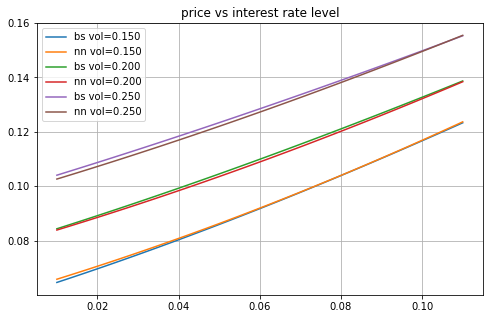

In [15]:
plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(8,5))
plt.grid(True)

vols=[.15,.2,.25]
for vc in vols:
    rc=torch.linspace(0.01,0.11,100,device=device)
    srvc=torch.zeros((100,3),device=device)

    srvc[:,0]=1.0
    srvc[:,1]=rc
    srvc[:,2]=vc
    
    p_bs=call_bs(1.0,1.0,rc.cpu().numpy(),0.0,1.0,vc)
    p_nn=model_price(srvc)
    plt.plot(rc.cpu().numpy(),p_bs,label="bs vol="+ "%.3f" % vc)
    plt.plot(rc.cpu().numpy(),p_nn.cpu().view(100).detach().numpy(),
           label="nn vol="+ "%.3f" % vc)

plt.title("price vs interest rate level")
plt.legend()
#plt.savefig("test.svg")
plt.show()

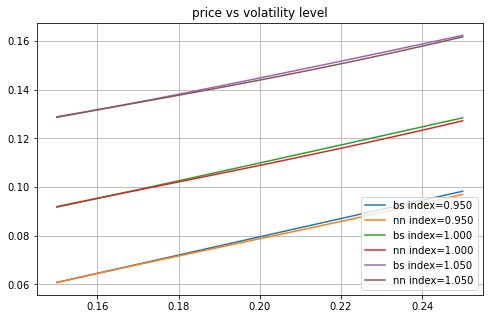

In [16]:
plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(8,5))
plt.grid(True)

rfc=0.06
scs=[.95,1,1.05]
for sc in scs:

    vc=torch.linspace(0.15,0.25,100,device=device)
    
    srvc=torch.zeros((100,3),device=device)

    srvc[:,0]=sc
    srvc[:,1]=rfc
    srvc[:,2]=vc
    
    p_bs=call_bs(sc,1.0,rfc,0.0,1.0,vc.cpu().numpy())
    p_nn=model_price(srvc)
    plt.plot(vc.cpu().numpy(),p_bs,label="bs index="+ "%.3f" % sc)
    plt.plot(vc.cpu().numpy(),p_nn.cpu().view(100).detach().numpy(),
           label="nn index="+ "%.3f" % sc)

plt.title("price vs volatility level")
plt.legend()
#plt.savefig("test.svg")
plt.show()

We should see the neural network price and Black Scholes price very close as well. 

## Discussion and conclusion

We demonstrated a method to train a neural network as a proxy of delta of financial options and discussed implication applying this method to AAA scenario and variable annuity cashflow. 

Here we studied how to use a neural network to approximate the delta of a call option over the life the option. 

The data requirement for the process is small: a single set of scenario and cash flows. And we don’t really need any prior knowledge of financial mathematics or stochastic calculus. 

The delta is solved by maximizing the hedge effectiveness of the delta hedge strategy. There are literature shows Black-Scholes formula delta will produce the highest possible hedge effectiveness when the rebalancing is continuously. The delta from the solving process is extremely close to the Black-Scholes delta. The hedge effectiveness is actually higher with neural network compared to Black-Scholes delta, probably because of the discrete natual of rebalance. 


One implication is it’s now possible calculate the delta on each node along each path, giving scenario set and cash for a block of variable annuity.

There are several considering when applying this technique to AAA scenario:
* Monthly rebalancing is not good enough a delta hedge. We need to either model a gamma hedge asset and/or an approximation of daily rebalancing. 
* Additional input to the neural network is needed for feature such as high watermark etc.
* It’s possible to add CTE as one of the optimizing target. 
* The hedge effectiveness will be lower because the randomness in the volatility is difficult to hedge. 

One limitation of the approaches are:

*  Reproducibility. Because of the natural of the neural network training technique, the resulting delta function tend to slightly different in the end. But this is partially mitigated by the similarly high hedge effectiveness, which means the slightly different delta probably doesn’t matter that much in practice.
* No intuition for individual neuron output. Only the final network output make sense.

